In [1]:
import matplotlib.pyplot as plt
import instrument_matrices as matrices
import pandas as pd
import numpy as np

# Setting Up Initial Instrument Parameters

In [2]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0  # Rough value from unpolarized standards fit
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For testing ideal parameters
# delta_FLC = 0.5
# em_gain = 1
# epsilon_opts = 0 # Made this zero for testing purposes

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Load Intensities

In [3]:
csv_file = "../data/unpolarized/csv/20240111_Eta_Crv_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv"
df = pd.read_csv(csv_file)
df.drop([208,209,210,211,212,213,214,215,216,217,218,219], inplace=True)

# Using Normalized Double Differences as the Observable

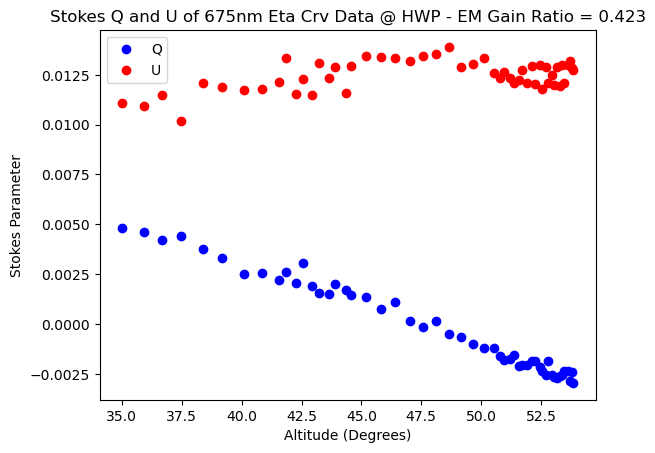

In [4]:
# Setting initial altitudes

# Lists for saving extracted Q and U
wavelength = 675
first_rows = []
diffs_and_sums = []
Q_list = []
U_list = []
final_altitudes = []
inst_matrices_at_HWP = []
this_cycle_intensities = []
this_cycle_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each target and calculate s_sky individually
for i, row in df.iterrows():
    HWP_ang = row["U_HWPANG"]
    IMR_ang = row["D_IMRANG"]
    cam_num = row["U_CAMERA"]
    FLC_state = row["U_FLCSTT"]
    altitude = row["ALTITUDE"]
    data_Q = row["Q"]

    # NOTE: This is for normalized differences
    double_difference = row["DOUBLE_DIFFERENCE"]
    double_sum = row["DOUBLE_SUM"]

    if double_difference != 0:

        # Append intensities and altitudes for this cycle
        this_cycle_intensities.append(double_difference)
        # this_cycle_intensities.append(double_sum)
        this_cycle_altitudes.append(altitude)

        # Calculate instrument matrix at HWP
        # NOTE: Altitude and parallactic angle are 0
        these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum( 
            model, fixed_params, 0, 0, HWP_ang, IMR_ang)
        double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
        double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

        # Setting the I component to be 1
        double_diff_matrix_at_HWP[0, 0] = 1

        # Saving instrument matrices
        inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
        inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

        # Take only the first row and I, Q, U, components (no V)
        first_rows.append(double_diff_matrix_at_HWP[0, : 3])  
        # first_rows.append(double_sum_matrix_at_HWP[0, : ])  

        # Printing information
        # print("Altitude: " + str(altitude))
        # print("HWP Angle: " + str(HWP_ang))
        # print("IMR Angle: " + str(IMR_ang))
        # print("Measured Double Difference: " + str(double_difference))
        # print("Measured Double Sum: " + str(double_sum))
        # print("Double Difference Matrix: " + str(double_diff_matrix_at_HWP))
        # print("Double Sum Matrix: " + str(double_sum_matrix_at_HWP))

    # Do one inversion for one HWP cycle
    if data_Q != 0:
        # Constructing measurement matrix to reconstruct Stokes vector at HWP
        measurement_matrix = np.vstack(first_rows)
        measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector

        # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
        # NOTE: s_HWP is the stokes vector at the HWP
        s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

        # print("HWP Stokes Vector")
        # print(s_HWP)

        # Extract Q and U from s_HWP_normalized
        Q = s_HWP[1]
        U = s_HWP[2]

        # Append Q, U, altitude to the lists
        Q_list.append(Q)
        U_list.append(U)

        # Saving the mean of the altitudes
        mean_altitude = np.mean(this_cycle_altitudes)

        # Reset measurement matrix rows and double diff and sum measurements
        first_rows = []  
        this_cycle_intensities = []
        this_cycle_altitudes = []

        counter = 0 

        final_altitudes.append(mean_altitude)

# Assuming 'altitudes', 'Q_list', and 'U_list' are already defined
plt.plot(final_altitudes, Q_list, label='Q', linestyle='None', marker='o', color='blue')
plt.plot(final_altitudes, U_list, label='U', linestyle='None', marker='o', color='red')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes Parameter")
plt.legend() 
plt.show()


# Generate fake data

In [5]:
# Setting initial altitudes
# delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0.012  # Rough value from unpolarized standards fit
# offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
# em_gain = 0.423  # Add your actual em_gain value
# delta_HWP = 0.451  # Add your actual delta_HWP value
# offset_HWP = -2.642  # Add your actual offset_HWP value
# delta_derot = 0.32  # Add your actual delta_derot value
# offset_derot = -0.011  # Add your actual offset_derot value
# delta_opts = -0.163  # Add your actual delta_opts value
# epsilon_opts = 0.036  # Add your actual epsilon_opts value
# rot_opts = -7.151  # Add your actual rot_opts value
# delta_FLC = 0.302  # Add your actual delta_FLC value
# rot_FLC = 0.256  # Add your actual rot_FLC value

## Ideal everything
# delta_m3 = 0 # (waves) - assumed to be zero for now
# epsilon_m3 = 0.015  # Rough value from unpolarized standards fit
# offset_m3 = 0  # NOTE: Made this zero too for testing purposes
# em_gain = 1  # Add your actual em_gain value
# delta_HWP = 0.5  # Add your actual delta_HWP value
# offset_HWP = 0  # Add your actual offset_HWP value
# delta_derot = 0.5  # Add your actual delta_derot value
# offset_derot = 0  # Add your actual offset_derot value
# delta_opts = 0  # Add your actual delta_opts value
# epsilon_opts = 0  # Add your actual epsilon_opts value
# rot_opts = 0  # Add your actual rot_opts value
# delta_FLC = 0.5  # Add your actual delta_FLC value
# rot_FLC = 0  # Add your actual rot_FLC value

# delta_FLC = 0.5
# em_gain = 1
# epsilon_opts = 0 # Made this zero for testing purposes

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Lists for saving extracted Q and U
wavelength = 675
first_rows = []
diffs_and_sums = []
all_altitudes = []
this_cycle_intensities = []
this_cycle_altitudes = []

all_stokes = []

model = matrices.full_system_mueller_matrix

# Loop through each target and calculate s_sky individually
for i, row in df.iterrows():
    HWP_ang = row["U_HWPANG"]
    IMR_ang = row["D_IMRANG"]
    cam_num = row["U_CAMERA"]
    FLC_state = row["U_FLCSTT"]
    altitude = row["ALTITUDE"]
    data_Q = row["Q"]

    # NOTE: This is for normalized differences
    double_difference = row["DOUBLE_DIFFERENCE"]
    double_sum = row["DOUBLE_SUM"]

    if double_difference != 0:

        # Append intensities and altitudes for this cycle
        this_cycle_intensities.append(double_difference)
        # this_cycle_intensities.append(double_sum)
        this_cycle_altitudes.append(altitude)

        # Calculate instrument matrix at HWP
        # NOTE: Altitude and parallactic angle are 0
        these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum( 
            model, fixed_params, 0, altitude, HWP_ang, IMR_ang)
        double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
        double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]


        stokes = double_diff_matrix_at_HWP @ [1,0,0,0]

        all_stokes.append(stokes)
        all_altitudes.append(altitude)
        # Setting the I component to be 1
        # double_diff_matrix_at_HWP[0, 0] = 1

        # # Saving instrument matrices
        # inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
        # inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

        # # Take only the first row and I, Q, U, components (no V)
        # first_rows.append(double_diff_matrix_at_HWP[0, : 3])  
        # first_rows.append(double_sum_matrix_at_HWP[0, : ])  

        # Printing information
        # print("Altitude: " + str(altitude))
        # print("HWP Angle: " + str(HWP_ang))
        # print("IMR Angle: " + str(IMR_ang))
        # print("Measured Double Difference: " + str(double_difference))
        # print("Measured Double Sum: " + str(double_sum))
        # print("Double Difference Matrix: " + str(double_diff_matrix_at_HWP))
        # print("Double Sum Matrix: " + str(double_sum_matrix_at_HWP))

    # Do one inversion for one HWP cycle
    # if data_Q != 0:
    #     # Constructing measurement matrix to reconstruct Stokes vector at HWP
    #     measurement_matrix = np.vstack(first_rows)
    #     measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector

    #     # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
    #     # NOTE: s_HWP is the stokes vector at the HWP
    #     s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

    #     print("HWP Stokes Vector")
    #     print(s_HWP)

    #     # Extract Q and U from s_HWP_normalized
    #     Q = s_HWP[1]
    #     U = s_HWP[2]

    #     # Append Q, U, altitude to the lists
    #     Q_list.append(Q)
    #     U_list.append(U)

    #     # Saving the mean of the altitudes
    #     mean_altitude = np.mean(this_cycle_altitudes)

    #     # Reset measurement matrix rows and double diff and sum measurements
    #     first_rows = []  
    #     this_cycle_intensities = []
    #     this_cycle_altitudes = []

    #     counter = 0 

    #     final_altitudes.append(mean_altitude)

# all_stokes = np.array(all_stokes)
# # Assuming 'altitudes', 'Q_list', and 'U_list' are already defined
# plt.plot(final_altitudes[::4], all_stokes[::4,1], label='Q', linestyle='None', marker='o', color='blue')
# # plt.plot(final_altitudes, U_list, label='U', linestyle='None', marker='o', color='red')

# plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
# plt.xlabel("Altitude (Degrees)")
# plt.ylabel("Stokes Parameter")
# plt.legend() 
# plt.show()


In [6]:
# all_stokes = np.array(all_stokes)
# plt.plot(all_altitudes[::4], (all_stokes[::4,0]-all_stokes[1::4,0]), label='Q', linestyle='None', marker='o', color='blue')
# plt.plot(all_altitudes[::4], (all_stokes[2::4,0]-all_stokes[3::4,0]), label='U', linestyle='None', marker='o', color='blue')
# # plt.plot(final_altitudes, U_list, label='U', linestyle='None', marker='o', color='red')

# plt.plot(final_altitudes, Q_list, label='Q', linestyle='None', marker='o', color='C2')
# plt.plot(final_altitudes, np.array(U_list), label='U', linestyle='None', marker='o', color='C3')

# plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
# plt.xlabel("Altitude (Degrees)")
# plt.ylabel("Stokes Parameter")
# plt.legend() 
# plt.show()


/var/folders/sl/x_3b4pw92c72tk267vfk6j5r0000gn/T/ipykernel_52771/1406092869.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(final_altitudes,0.5*(df["DOUBLE_DIFFERENCE"][::4][0::4].values-df["DOUBLE_DIFFERENCE"][0::4][1::4].values),'o',label="Data Triple Difference Q")
/var/folders/sl/x_3b4pw92c72tk267vfk6j5r0000gn/T/ipykernel_52771/1406092869.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(final_altitudes,0.5*(df["DOUBLE_DIFFERENCE"][::4][2::4].values-df

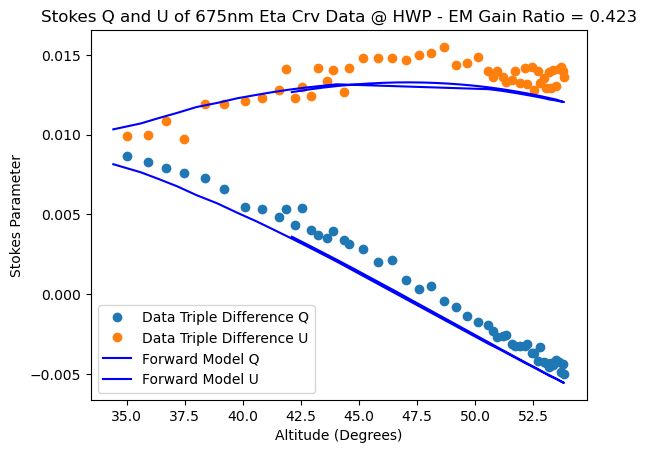

In [7]:

plt.plot(final_altitudes,0.5*(df["DOUBLE_DIFFERENCE"][::4][0::4].values-df["DOUBLE_DIFFERENCE"][0::4][1::4].values),'o',label="Data Triple Difference Q")
plt.plot(final_altitudes,0.5*(df["DOUBLE_DIFFERENCE"][::4][2::4].values-df["DOUBLE_DIFFERENCE"][0::4][3::4].values),'o',label="Data Triple Difference U")

all_stokes = np.array(all_stokes)
plt.plot(all_altitudes[::4], 0.5*(all_stokes[::4,0]-all_stokes[1::4,0]), label='Forward Model Q', color='blue')
plt.plot(all_altitudes[::4], 0.5*(all_stokes[2::4,0]-all_stokes[3::4,0]), label='Forward Model U', color='blue')
# plt.plot(final_altitudes, U_list, label='U', linestyle='None', marker='o', color='red')

# plt.plot(final_altitudes, Q_list, label='Q', linestyle='None', marker='o', color='C2')
# plt.plot(final_altitudes, np.array(U_list), label='U', linestyle='None', marker='o', color='C3')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes Parameter")
plt.legend() 
plt.show()


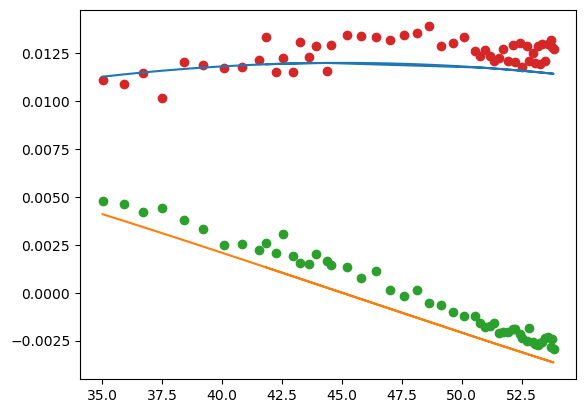

In [8]:
fig, axes  = plt.subplots(1,1)
plt.plot(final_altitudes, np.array(Q_list), label='Inverted Q', linestyle='None', marker='o', color='C2')
plt.plot(final_altitudes, np.array(U_list), label='Inverted U', linestyle='None', marker='o', color='C3')

plt.plot(final_altitudes, epsilon_m3*np.sin(2*np.radians(final_altitudes)), )
plt.plot(final_altitudes, epsilon_m3*np.cos(2*np.radians(final_altitudes)), )


# axes.axhline(0.)
# axes.axvline(45.)

# Printing Instrumental Matrices

In [11]:
print("Example Double Difference Matrices")
print(inst_matrices_at_HWP[-4])
print(inst_matrices_at_HWP[-2])
print("Example Double Sum Matrices")
print(inst_matrices_at_HWP[-3])
print(inst_matrices_at_HWP[-1])


Example Double Difference Matrices
[[ 0.03263141 -0.21218493  1.08147101  0.33768842]
 [-0.01323143  0.08603704 -0.43851635 -0.13692637]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 0.03263141 -0.00270819 -1.06924875  0.43050577]
 [-0.01323143  0.00109812  0.43356046 -0.17456207]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Example Double Sum Matrices
[[ 1.4161659   0.01158391 -0.05108753  0.30773666]
 [-0.56014572 -0.01818822  0.22627937 -0.79023198]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 1.4161659  -0.1361671   0.06696269  0.2728012 ]
 [-0.56014572  0.33437124 -0.26650057 -0.70226283]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


# Testing Mueller Matrices

In [12]:
delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0  # Rough value from unpolarized standards fit
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

HWP_ang = 0
IMR_ang = 80
FLC_state = 1

test_matrix_1 = matrices.full_system_mueller_matrix( 
    *fixed_params, 0, 0, HWP_ang, IMR_ang, 1, FLC_state)

print("Test Matrix (Cam 1): " + str(test_matrix_1))

test_matrix_2 = matrices.full_system_mueller_matrix( 
    *fixed_params, 0, 0, HWP_ang, IMR_ang, 2, FLC_state)

print("Test Matrix (Cam 2): " + str(test_matrix_2))

test_double_diff_and_sum_matrices = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum( 
    model, fixed_params, 0, 0, HWP_ang, IMR_ang)
test_double_diff_matrix = test_double_diff_and_sum_matrices[0]
test_double_sum_matrix = test_double_diff_and_sum_matrices[1]

print("Test Matrix (DD): " + str(test_double_diff_matrix))
print("Test Matrix (DS): " + str(test_double_sum_matrix))

Test Matrix (Cam 1): [[ 0.21885504  0.19508735  0.0983739  -0.01268977]
 [ 0.21885504  0.19508735  0.0983739  -0.01268977]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Test Matrix (Cam 2): [[ 0.4826122  -0.42607138 -0.2246879   0.02988412]
 [-0.4826122   0.42607138  0.2246879  -0.02988412]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Test Matrix (DD): [[ 0.03263141  0.80563758  0.55887106  0.60600881]
 [-0.01323143 -0.32667104 -0.22661181 -0.24572529]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Test Matrix (DS): [[ 1.4161659  -0.13529702 -0.0260162   0.28011399]
 [-0.56014572  0.43667988  0.08725254 -0.69115659]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
